In [7]:
!pip3 -q install catboost
!pip -q install fast_ml

In [8]:
import pandas as pd
import numpy as np 

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.model_selection import train_test_split
from catboost import CatBoostRegressor
import catboost as cbr
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import StackingRegressor
from xgboost import XGBRegressor

# for checking performance
from sklearn import metrics

from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.metrics import mean_squared_error

from fast_ml.feature_engineering import FeatureEngineering_Numerical, FeatureEngineering_Categorical, FeatureEngineering_DateTime
from fast_ml.outlier_treatment import OutlierTreatment
from fast_ml.missing_data_analysis import MissingDataAnalysis
from fast_ml.model_evaluation import threshold_evaluation
from fast_ml.feature_selection import get_constant_features
from fast_ml.model_development import train_valid_test_split
from fast_ml.model_evaluation import threshold_evaluation
from fast_ml import eda

In [10]:
dftrain = pd.read_csv('/content/job_hack_train.csv')
dftest = pd.read_csv('/content/job_hack_test.csv')

In [11]:
dftrain.head()

,row_id,datetime,energy
0,1,2008-03-01 00:00:00,1259.985563
1,2,2008-03-01 01:00:00,1095.541500
2,3,2008-03-01 02:00:00,1056.247500
3,4,2008-03-01 03:00:00,1034.742000
4,5,2008-03-01 04:00:00,1026.334500


In [12]:
dftest.head()

,row_id,datetime
0,94993,2019-01-01 00:00:00
1,94994,2019-01-01 01:00:00
2,94995,2019-01-01 02:00:00
3,94996,2019-01-01 03:00:00
4,94997,2019-01-01 04:00:00


## Exploratory Data Analysis

In [13]:
dftrain.shape,dftest.shape

((94992, 3), (26304, 2))

In [14]:
dftrain.info(),
print('\n===================\n')
dftest.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94992 entries, 0 to 94991
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   row_id    94992 non-null  int64  
 1   datetime  94992 non-null  object 
 2   energy    93092 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 2.2+ MB


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26304 entries, 0 to 26303
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   row_id    26304 non-null  int64 
 1   datetime  26304 non-null  object
dtypes: int64(1), object(1)
memory usage: 411.1+ KB


In [15]:
print(dftrain.isna().sum()),
print('==================')
dftest.isna().sum()

row_id         0
datetime       0
energy      1900
dtype: int64


row_id      0
datetime    0
dtype: int64

## Data Cleaning

In [16]:
dftrain = dftrain.fillna(dftrain.interpolate())
dftrain.shape

(94992, 3)

## Feature Engineering


Covert the datetime columns of the dataframes to datetime objects


In [17]:
dftrain.datetime = pd.to_datetime(dftrain.datetime)
dftest.datetime = pd.to_datetime(dftest.datetime)

Make copies of the dataframes


In [18]:
df_train = dftrain.copy()
df_test = dftest.copy()

Temporarily drop row_id column from copied datafrmes

In [19]:
df_train = df_train.drop('row_id', axis = 1)
df_test = df_test.drop('row_id', axis = 1)

Set datetime column as index

In [20]:
df_train = df_train.set_index('datetime')
df_test = df_test.set_index('datetime')

Energy evolution

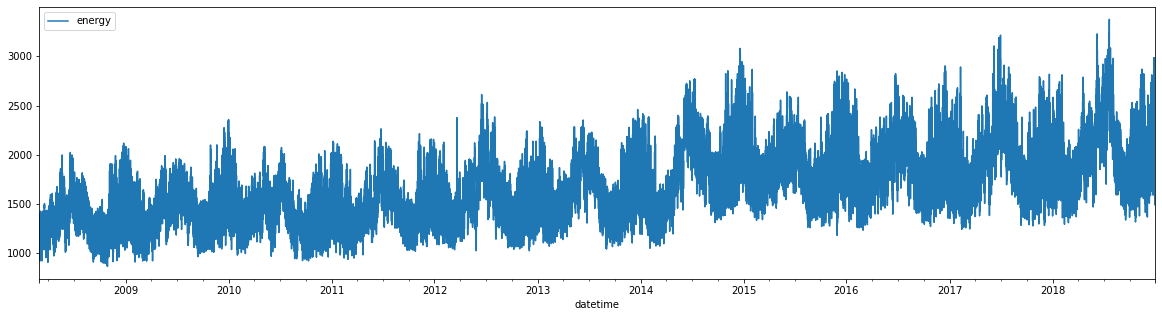

In [21]:
df_train.plot(figsize=(20,5))

Autotorelation

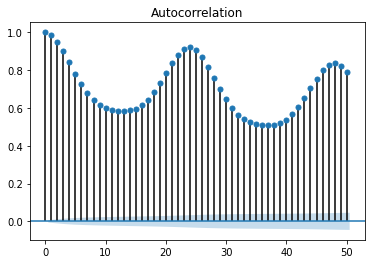

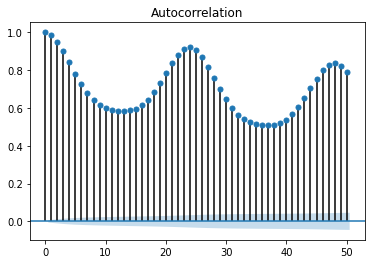

In [22]:
plot_acf(df_train)


Partial autotorelation

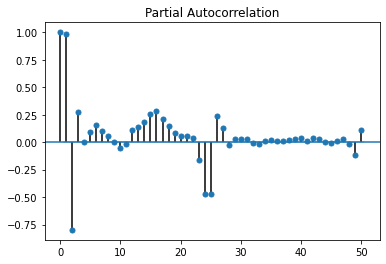

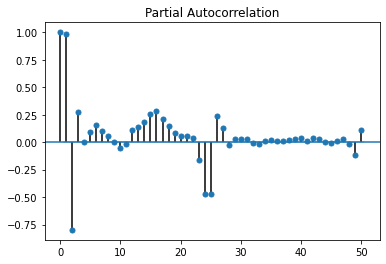

In [23]:
plot_pacf(df_train)


In [24]:
df_test = dftest.copy()
df_train = dftrain.copy()

Create more features from datetime

In [25]:
fe = FeatureEngineering_DateTime()

fe.fit(df_train, datetime_variables=['datetime'], prefix = 'data ')
df_train = fe.transform(df_train)

fe.fit(df_test, datetime_variables=['datetime'], prefix = 'data ')
df_test = fe.transform(df_test)


Create columns in the **df_train** data

In [26]:
df_train["month_end"] = df_train["data is_month_end"].astype(int)
df_train["month_start"] = df_train["data is_month_start"].astype(int)
df_train["quarter_end"] = df_train["data is_quarter_end"].astype(int)
df_train["quarter_start"] = df_train["data is_quarter_start"].astype(int)
df_train["year_start"] = df_train["data is_year_start"].astype(int)
df_train["year_end"] = df_train["data is_year_end"].astype(int)

Create columns in the **df_test** data


In [27]:
df_test["month_end"] = df_test["data is_month_end"].astype(int)
df_test["month_start"] = df_test["data is_month_start"].astype(int)
df_test["quarter_end"] = df_test["data is_quarter_end"].astype(int)
df_test["quarter_start"] = df_test["data is_quarter_start"].astype(int)
df_test["year_start"] = df_test["data is_year_start"].astype(int)
df_test["year_end"] = df_test["data is_year_end"].astype(int)

Drop the unneeded columns from the dataframes


In [28]:
df_train = df_train[:len(df_train)].drop(['datetime','data day_part','data time'],axis=1)
df_test = df_test[:len(df_test)].drop(['datetime','data day_part','data time'],axis=1)

In [29]:
df_train.head()

,row_id,energy,data year,data quarter,data month,data day,data day_of_week,data day_of_year,data weekofyear,data is_month_end,...,data hour,data minute,data second,data is_weekend,month_end,month_start,quarter_end,quarter_start,year_start,year_end
0,1,1259.985563,2008,1,3,1,5,61,9,False,...,0,0,0,1,0,1,0,0,0,0
1,2,1095.541500,2008,1,3,1,5,61,9,False,...,1,0,0,1,0,1,0,0,0,0
2,3,1056.247500,2008,1,3,1,5,61,9,False,...,2,0,0,1,0,1,0,0,0,0
3,4,1034.742000,2008,1,3,1,5,61,9,False,...,3,0,0,1,0,1,0,0,0,0
4,5,1026.334500,2008,1,3,1,5,61,9,False,...,4,0,0,1,0,1,0,0,0,0


In [30]:
df_test.head()

,row_id,data year,data quarter,data month,data day,data day_of_week,data day_of_year,data weekofyear,data is_month_end,data is_month_start,...,data hour,data minute,data second,data is_weekend,month_end,month_start,quarter_end,quarter_start,year_start,year_end
0,94993,2019,1,1,1,1,1,1,False,True,...,0,0,0,0,0,1,0,1,1,0
1,94994,2019,1,1,1,1,1,1,False,True,...,1,0,0,0,0,1,0,1,1,0
2,94995,2019,1,1,1,1,1,1,False,True,...,2,0,0,0,0,1,0,1,1,0
3,94996,2019,1,1,1,1,1,1,False,True,...,3,0,0,0,0,1,0,1,1,0
4,94997,2019,1,1,1,1,1,1,False,True,...,4,0,0,0,0,1,0,1,1,0


Reset index to row_id

In [31]:
df_train = df_train.set_index('row_id')
df_test = df_test.set_index('row_id')

## Data Preprocessing
Set the features and label

In [32]:
# features
X = df_train.drop('energy', axis=1)

# label
y = df_train["energy"]

Scale the features

In [33]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()
X_scaled = scaler.fit_transform(X)
test_scaled = scaler.transform(df_test)

Split data into train and test sets


In [34]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=50)
#print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, test_scaled.shape)

## Modeling
CatBoost

In [38]:
training = cbr.Pool(X_train, y_train) 
testing = cbr.Pool(X_test, y_test)

my_model = cbr.CatBoostRegressor(loss_function='RMSE', verbose = False)

grid = {'iterations': [100, 150, 200],
        'learning_rate': [0.03, 0.1],
        'depth': [2, 4, 6, 8],
        'l2_leaf_reg': [0.2, 0.5, 1, 3]}

my_model.grid_search(grid, training)
my_model.fit(X_train, y_train)



bestTest = 254.7056718
bestIteration = 99

0:	loss: 254.7056718	best: 254.7056718 (0)	total: 738ms	remaining: 1m 10s

bestTest = 187.1859032
bestIteration = 99

1:	loss: 187.1859032	best: 187.1859032 (1)	total: 1.4s	remaining: 1m 5s

bestTest = 254.7086617
bestIteration = 99

2:	loss: 254.7086617	best: 187.1859032 (1)	total: 2.04s	remaining: 1m 3s

bestTest = 187.1490438
bestIteration = 99

3:	loss: 187.1490438	best: 187.1490438 (3)	total: 2.66s	remaining: 1m 1s

bestTest = 254.8282869
bestIteration = 99

4:	loss: 254.8282869	best: 187.1490438 (3)	total: 3.33s	remaining: 1m

bestTest = 187.1895645
bestIteration = 99

5:	loss: 187.1895645	best: 187.1490438 (3)	total: 3.96s	remaining: 59.5s

bestTest = 254.8479439
bestIteration = 99

6:	loss: 254.8479439	best: 187.1490438 (3)	total: 4.62s	remaining: 58.8s

bestTest = 187.1990692
bestIteration = 99

7:	loss: 187.1990692	best: 187.1490438 (3)	total: 5.78s	remaining: 1m 3s

bestTest = 223.0874023
bestIteration = 149

8:	loss: 223.0874023	b

In [39]:
#  make prediction with X_test data
pred_model = my_model.predict(X_test)

# Evaluate result from the gradient boosting regression model
print("Accuracy of the Gradient Boosting Regression model is",r2_score(y_test,pred_model))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,pred_model)), '\nMAE: ',mean_absolute_error(y_test, pred_model))


Accuracy of the Gradient Boosting Regression model is 0.9137934638414015
RMSE:  108.69161009853833 
MAE:  82.11854761251392


#### CatBoost Regression Model


In [40]:
cbr = CatBoostRegressor(iterations=10,
                        learning_rate = 1,
                        loss_function = 'RMSE',
                        depth=6,
                        verbose = False,
                        random_state = 0)
cbr.fit(X_train, y_train)

0:	learn: 223.6599342	total: 12.6ms	remaining: 113ms
1:	learn: 194.3110018	total: 27.5ms	remaining: 110ms
2:	learn: 181.6636857	total: 45.9ms	remaining: 107ms
3:	learn: 172.9177352	total: 58.1ms	remaining: 87.1ms
4:	learn: 169.9826968	total: 69.9ms	remaining: 69.9ms
5:	learn: 162.9226413	total: 82.1ms	remaining: 54.7ms
6:	learn: 157.0316905	total: 94.8ms	remaining: 40.6ms
7:	learn: 153.3123899	total: 107ms	remaining: 26.7ms
8:	learn: 150.2008732	total: 119ms	remaining: 13.2ms
9:	learn: 148.1302226	total: 131ms	remaining: 0us


In [41]:
#  make prediction with X_test data
c_pred = cbr.predict(X_test)

# Evaluate result from the cat boosting regression model
print("Accuracy of the Cat Boosting Regression model is",r2_score(y_test,c_pred))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,c_pred)), '\nMAE: ',mean_absolute_error(y_test, c_pred))


Accuracy of the Cat Boosting Regression model is 0.8368954329602039
RMSE:  149.50612506776378 
MAE:  114.22708338328415


#### XGBoost

In [43]:
# define model
xgb = XGBRegressor(learning_rate = 0.1,
                   max_depth = 100,
                   colsample_bytree = 0.5,
                   n_estimators= 1000)

xgb.fit(X_train, y_train)


[10:24:58] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(colsample_bytree=0.5, max_depth=100, n_estimators=1000)

In [44]:
#  make prediction with X_test data
pred_xgb = xgb.predict(X_test)

# Evaluate result from the XGBooost regression model
print("Accuracy of the XGBooost Regression model is",r2_score(y_test,pred_xgb))
print("RMSE: ", np.sqrt(mean_squared_error(y_test,pred_xgb)), '\nMAE: ',mean_absolute_error(y_test, pred_xgb))


Accuracy of the XGBooost Regression model is 0.9917125398367332
RMSE:  33.70052383555381 
MAE:  23.68612171863726


Make prediction with **unseen data**


In [51]:
pred_xgb = xgb.predict(test_scaled)
pred_xgb

array([1712.6604, 1546.6765, 1453.548 , ..., 2294.7466, 2217.9995,
       2119.1177], dtype=float32)

### Create Submission File

In [52]:
# To create Dataframe for prediction
my_submission = pd.DataFrame({'row_id': df_test.index, 'energy': pred_xgb})

# convert to csv
my_submission.to_csv('pred_xgb3.csv', index=False)
